<a href="https://colab.research.google.com/github/cucai-ducvubka/new-app-2024/blob/master/vae_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pillow diffusers torchvision torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

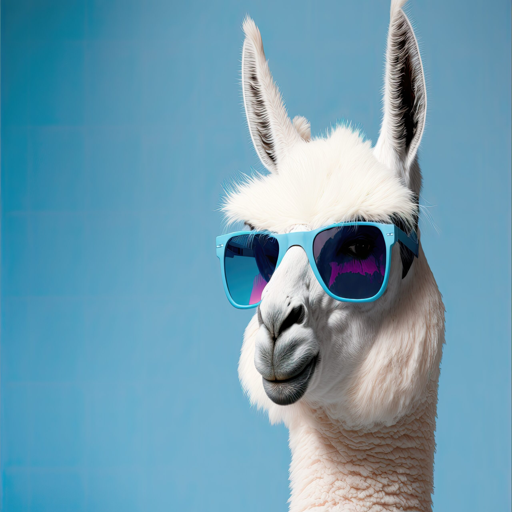

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Latent shape: torch.Size([1, 4, 64, 64])


In [2]:
from PIL import Image
from torchvision import transforms
from diffusers import AutoencoderKL
import requests
import torch

# Tải ảnh và resize lại thành 512x512
url = "https://assets.hoccodeai.com/02.3-Diffusion-diffuser/imgs/llama.jpg"
input_image = Image.open(requests.get(url, stream=True).raw)
input_image = input_image.resize((512, 512))
display(input_image)

# Tải autoencoder để chuẩn bị nén ảnh
vae = AutoencoderKL.from_pretrained("sd-legacy/stable-diffusion-v1-5", subfolder="vae")
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = vae.to(device)

# Nén ảnh thành latent với vae.encode
with torch.no_grad():
    tensor_im = transforms.ToTensor()(input_image).unsqueeze(0).to(device) * 2 - 1
    latent = vae.encode(tensor_im)  # Encode ảnh thành latent

    latents = latent.latent_dist.sample()
    latents = latents * 0.18   215

print("Latent shape:", latents.shape)

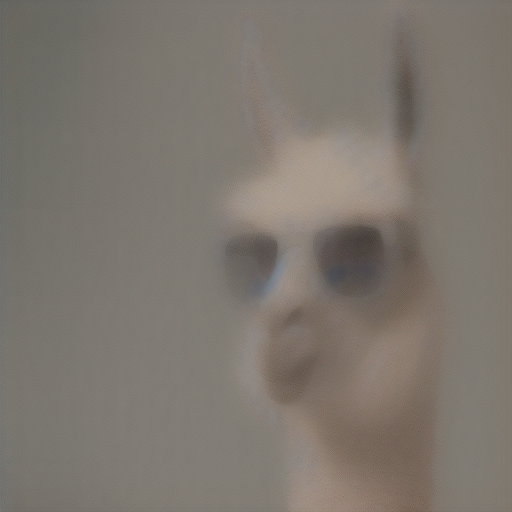

In [3]:
# Giải nén ảnh bằng vae.decode
with torch.no_grad():
  image = vae.decode(latents).sample
  # Display
  image = (image / 2 + 0.5).clamp(0, 1)
  image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
  images = (image * 255).round().astype("uint8")
  pil_images = [Image.fromarray(image) for image in images]
  display(pil_images[0])

In [4]:
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

# Tokenizer chuyển prompt thành 1 chuỗi các token
prompt = "A photograph of a puppy"
text_input = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )

# In dần dần từng token ra
for t in text_input["input_ids"][0][:8]:
    print(t, tokenizer.decoder.get(int(t)))

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(8853) photograph</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [5]:
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = text_encoder.to(device)
text_embeddings = text_encoder(text_input.input_ids.to(device))[0]
print(text_embeddings)

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.4595,  0.5617,  1.6663,  ..., -1.9515, -1.2307,  0.0104],
         ...,
         [-0.0220, -0.0967,  0.1025,  ..., -0.1302, -1.2414,  0.0722],
         [-0.0078, -0.1249,  0.1193,  ..., -0.1303, -1.2277,  0.0789],
         [-0.0210, -0.0810,  0.1538,  ..., -0.1321, -1.2184,  0.0358]]],
       grad_fn=<NativeLayerNormBackward0>)
